In [ ]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:
# Collecting Words
path = '/content/drive/MyDrive/Colab Notebooks/AndrejKarpathy_NN_Hero/names.txt'
words = open(path, 'r').read().splitlines()

# Mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
block_size = 3 # number of characters as input
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# Split the dataset (train: 80%, dev: 10%, test:10%)
rs = 2147483647
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.8, random_state=rs, shuffle=True)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, train_size=0.5, random_state=rs, shuffle=True)

## Fixing the Initial Loss

In [ ]:
# Problem Statement: We are getting a very high initial loss (on i=0)
# Because the weights and biases are randomly selected and they can be large positive numbers

# We can dial this down, by making the weights and biases as uniform as possible
# Getting them all close to zero is one way of doing it.

In [ ]:
# if all of the probabilities are uniformly distributed on first iteration itself
# then each probability will be = [1/27, 1/27, ..]
# we only alter the weights and biases of 2nd layer
    # as we are getting probabilities out of logits only from 2nd layer

loss = -torch.tensor(1/27).log()
loss # this is out expected initial loss = 3.29

tensor(3.2958)

In [ ]:
# Initializing parameters
g = torch.Generator().manual_seed(2147483647)
n_emb = 10 # number of embedding layers
n_h = 200 # number of Neurons in hidden layer

C = torch.randn((27, n_emb), generator=g)
w1 = torch.randn(( n_emb * block_size, n_h), generator=g) * 0.2
b1 = torch.randn((n_h), generator=g) * 0.01
w2 = torch.randn((n_h, 27), generator=g) * 0.01
b2 = torch.zeros((27))

params = [C, w1, b1, w2, b2]
for p in params:
    p.requires_grad = True

print(sum(p.nelement() for p in params)) # total params

11897


In [ ]:
ix = torch.randint(low=0, high=X_train.shape[0], size=(32, ), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

# forward pass
emb = C[Xb] # embed lookup
emb_cat = emb.view(emb.shape[0], -1) # concatenated embeds
h_preact = emb_cat @ w1 + b1 # pre activation
h = torch.tanh(h_preact) # activation of hidden layer
logits = h @ w2 + b2 # output layer
loss = F.cross_entropy(logits, Yb) # loss

# backward pass
for p in params:
    p.grad = None
loss.backward()

print(f'{loss=}')

loss=tensor(3.3166, grad_fn=<NllLossBackward0>)


In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    emb_cat = emb.view(emb.shape[0], -1) # concatenated embeds
    h_preact = emb_cat @ w1 + b1 # pre activation
    h = torch.tanh(h_preact) # activation of hidden layer
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())
print("Final Loss: ", loss.item())

Loss on iteration 0: 3.2911102771759033 | Learning Rate: 0.1
Loss on iteration 10000: 2.5495827198028564 | Learning Rate: 0.1
Loss on iteration 20000: 2.137460708618164 | Learning Rate: 0.1
Loss on iteration 30000: 2.2796385288238525 | Learning Rate: 0.1
Loss on iteration 40000: 2.050370931625366 | Learning Rate: 0.1
Loss on iteration 50000: 2.23323917388916 | Learning Rate: 0.1
Loss on iteration 60000: 2.138002872467041 | Learning Rate: 0.1
Loss on iteration 70000: 2.233466863632202 | Learning Rate: 0.1
Loss on iteration 80000: 2.099498987197876 | Learning Rate: 0.1
Loss on iteration 90000: 2.108109474182129 | Learning Rate: 0.1
Loss on iteration 100000: 2.1249325275421143 | Learning Rate: 0.01
Loss on iteration 110000: 2.0889241695404053 | Learning Rate: 0.01
Loss on iteration 120000: 2.084040641784668 | Learning Rate: 0.01
Loss on iteration 130000: 2.4409642219543457 | Learning Rate: 0.01
Loss on iteration 140000: 2.024739980697632 | Learning Rate: 0.01
Loss on iteration 150000: 2.2

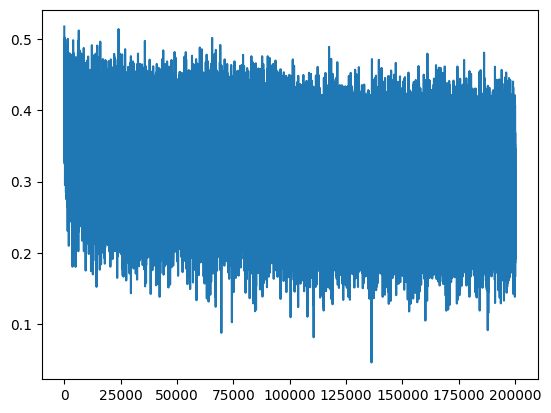

In [ ]:
plt.plot(lossi)

In [ ]:
# We have taken away the initial large loss, and the hockey stick appearance of the plot
# this is a good thing as we have removed the initial loss and got it down to expected value

In [ ]:
# DEV & TEST LOSS

@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    h = torch.tanh(emb.view(x.shape[0], -1) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.1173646450042725
test 2.114799976348877


## Fixing the Saturated tanh

In [ ]:
# Now, the loss looks fine.
# But we have another issue in our tanh function.
# if we look at an histogram of our tanh outputs

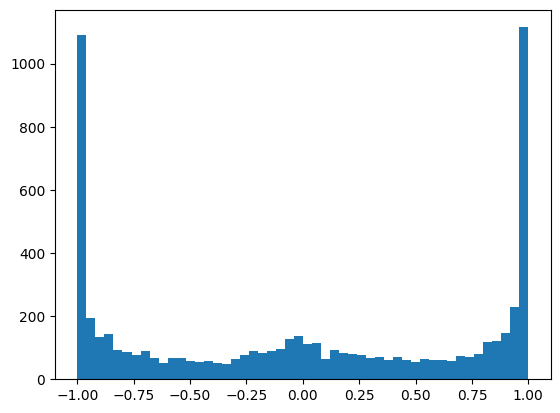

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50);

In [ ]:
# As we can see, most of the values are pushed to the extremes.
# so either 1 or -1

# If we take a look at the grad function for tanh:
# += (1- t**2) * out.grad

# So the closer our t value is to 1
    # the less our gradient will flow through the tanh function
    # when t=1, no gradient will flow through it, so our backprop stops there
# if all the tanh's in a Neuron are 0, it will never learn.

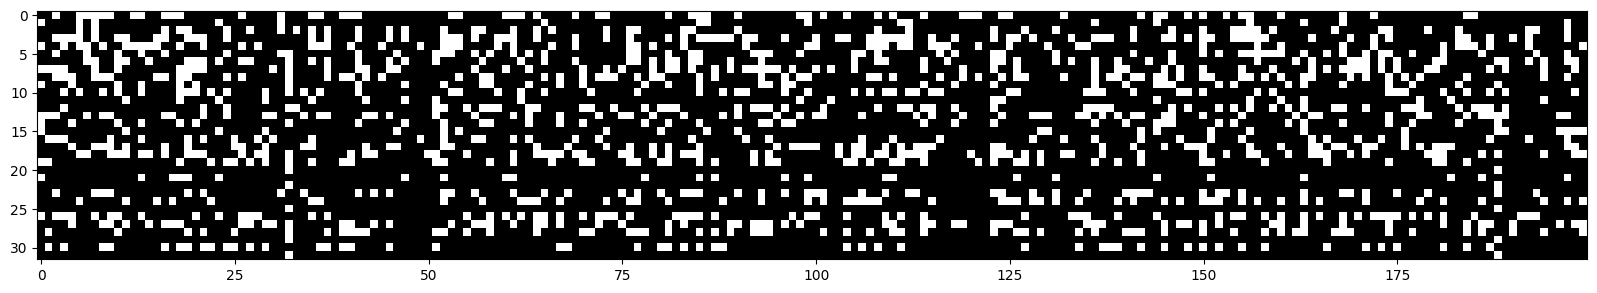

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

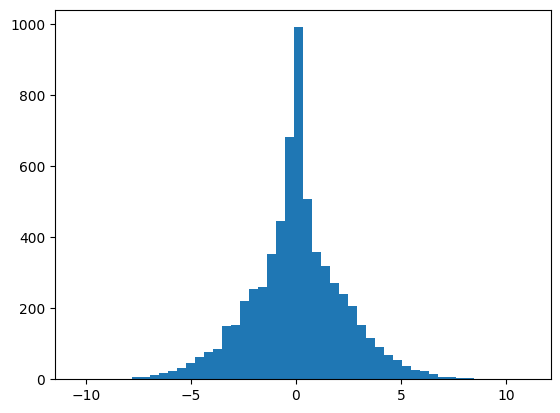

In [ ]:
plt.hist(h_preact.view(-1).tolist(), bins=50);

In [ ]:
# we can see that a lot of Neurons here, only 1 or 2 weights are black,
# only those are < 0.99
# if all of them are > 0.99, the Neuron will never learn. - Dead Neuron
# this is not optimal
    # we can solve this by getting the pre_act values close to 0
    # that will move our h (activated) values away from extremes

In [ ]:
# after implementing that,
    # we can see that all of our values are away from the extremes
    # can play around with the number for pre activation layer

## Kaiming Initialization

Kaiming et.al. Paper- Delving Deep into Rectifiers: [https://arxiv.org/pdf/1502.01852](https://arxiv.org/pdf/1502.01852)

Torch Documentation: https://docs.pytorch.org/docs/stable/nn.init.html

In [ ]:
# How are we choosing the number to multiply (scale) the weights with? 0.2 or 0.01

# there is a very standard method to do it: fan_in
# multiply it by this variable = gain * sqrt(1/n)
    # where n is the number of inputs to that layer
    # gain is dependant on the activation function we are using (5/3 for tanh)

# torch documentation on gains to be used: https://docs.pytorch.org/docs/stable/nn.init.html

# Kaiming initialization is only applied to weights of the layers which are followed by an activation layer
    # (layer1 is followed by tanh in our case)

In [ ]:
# Initializing parameters
g = torch.Generator().manual_seed(2147483647)
n_emb = 10 # number of embedding layers
n_h = 200 # number of Neurons in hidden layer

C = torch.randn((27, n_emb), generator=g)
w1 = torch.randn(( n_emb * block_size, n_h), generator=g) * (5/3)/((n_emb * block_size)**0.5) # Kaiming init
b1 = torch.randn((n_h), generator=g) * 0.01
w2 = torch.randn((n_h, 27), generator=g) * 0.01
b2 = torch.zeros((27))

params = [C, w1, b1, w2, b2]
for p in params:
    p.requires_grad = True

print(sum(p.nelement() for p in params)) # total params

11897


In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    emb_cat = emb.view(emb.shape[0], -1) # concatenated embeds
    h_preact = emb_cat @ w1 + b1 # pre activation
    h = torch.tanh(h_preact) # activation of hidden layer
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())
print("Final Loss: ", loss.item())

Loss on iteration 0: 3.2895302772521973 | Learning Rate: 0.1
Loss on iteration 10000: 2.5605554580688477 | Learning Rate: 0.1
Loss on iteration 20000: 2.1564412117004395 | Learning Rate: 0.1
Loss on iteration 30000: 2.318605422973633 | Learning Rate: 0.1
Loss on iteration 40000: 2.022270441055298 | Learning Rate: 0.1
Loss on iteration 50000: 2.1355483531951904 | Learning Rate: 0.1
Loss on iteration 60000: 2.1860666275024414 | Learning Rate: 0.1
Loss on iteration 70000: 2.243264675140381 | Learning Rate: 0.1
Loss on iteration 80000: 2.077852725982666 | Learning Rate: 0.1
Loss on iteration 90000: 1.9611493349075317 | Learning Rate: 0.1
Loss on iteration 100000: 2.0551815032958984 | Learning Rate: 0.01
Loss on iteration 110000: 2.0830068588256836 | Learning Rate: 0.01
Loss on iteration 120000: 2.128817081451416 | Learning Rate: 0.01
Loss on iteration 130000: 2.5154073238372803 | Learning Rate: 0.01
Loss on iteration 140000: 1.962658166885376 | Learning Rate: 0.01
Loss on iteration 150000:

In [ ]:
# DEV & TEST LOSS

@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    h = torch.tanh(emb.view(x.shape[0], -1) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.1194777488708496
test 2.1146037578582764


In [ ]:
# The loss is very close to the one we set manually (0.2)
# But now we have a standard procedure that can be used for much larger networks

## Batch Normalization

Batchnorm Paper: [Batch Normalization - Sergey Ioffe](https://arxiv.org/pdf/1502.03167)

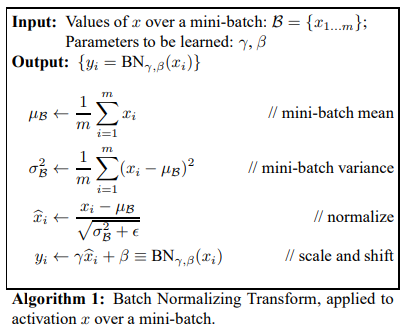

In [ ]:
# we did the Kaiming normalization method, so that our preactivated tensor values are roughly gaussian
    # having std. dev. around 1
# now that is done around initialization.

# for batchnorm, what we do is to make these gaussian at every iteration just before feeding it into activation function
    # so we normalize the hpreact each iteration,
    # but we don't want it to be perfectly gaussian each time, and want to give some control to the NN and backprop
    # we introduce it's own weight (gain) * bias into the equation

In [ ]:
# Normalization:

a = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) * 1.00
a_m = a.mean()
a_sd = a.std()

a_scaled = (a-a_m)/a_sd
a_scaled_mean = a_scaled.mean()
a_scaled_sd = a_scaled.std()

print(f'{a=}')
print(f'{a_m=}, {a_sd=}')
print(f'{a_scaled=}')
print(f'{a_scaled_mean=}, {a_scaled_sd=}')

a=tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
a_m=tensor(5.5000), a_sd=tensor(3.0277)
a_scaled=tensor([-1.4863, -1.1560, -0.8257, -0.4954, -0.1651,  0.1651,  0.4954,  0.8257,
         1.1560,  1.4863])
a_scaled_mean=tensor(0.), a_scaled_sd=tensor(1.)


In [ ]:
# We can see that the numbers are perfectly gaussian distributed now. mean=0, std=1
# we will follow the same logic in our NN

In [ ]:
# Initializing parameters
g = torch.Generator().manual_seed(2147483647)
n_emb = 10 # number of embedding layers
n_h = 200 # number of Neurons in hidden layer

C = torch.randn((27, n_emb), generator=g)
w1 = torch.randn(( n_emb * block_size, n_h), generator=g) * (5/3)/((n_emb * block_size)**0.5) # Kaiming init
b1 = torch.randn((n_h), generator=g) * 0.01
w2 = torch.randn((n_h, 27), generator=g) * 0.01
b2 = torch.zeros((27))

# batch norm
bngain = torch.ones((1, n_h))
bnbias = torch.zeros((1, n_h)) # one for each Neuron in the hidden layer

params = [C, w1, b1, w2, b2, bngain, bnbias]
for p in params:
    p.requires_grad = True

print(sum(p.nelement() for p in params)) # total params

12297


In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    emb_cat = emb.view(emb.shape[0], -1) # concatenated embeds
    h_preact = emb_cat @ w1 + b1 # pre activation
    # print(h_preact.shape) # [32, 200]
    # print(h_preact.mean(0, keepdims=True).shape) # [1, 200] -> broadcasted to [32, 200]
    # print(h_preact.std(0, keepdims=True).shape) # [1, 200] -> broadcasted to [32, 200]

    # batchnorm
    h_preact = bngain * ((h_preact - h_preact.mean(0, keepdims=True))/h_preact.std(0, keepdims=True)) + bnbias
    # print(bngain.shape)
    # print(bnbias.shape)
    # = gain * normalized_values + bias
    # normalized_values.shape = (n_inputs, n_h)
    # all the operations are element wise here

    h = torch.tanh(h_preact) # activation of hidden layer
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())
    # break

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.302973747253418 | Learning Rate: 0.1
Loss on iteration 10000: 2.545557975769043 | Learning Rate: 0.1
Loss on iteration 20000: 2.1655564308166504 | Learning Rate: 0.1
Loss on iteration 30000: 2.368164300918579 | Learning Rate: 0.1
Loss on iteration 40000: 2.176831007003784 | Learning Rate: 0.1
Loss on iteration 50000: 2.2558395862579346 | Learning Rate: 0.1
Loss on iteration 60000: 2.219064950942993 | Learning Rate: 0.1
Loss on iteration 70000: 2.1621110439300537 | Learning Rate: 0.1
Loss on iteration 80000: 2.0343637466430664 | Learning Rate: 0.1
Loss on iteration 90000: 2.2060532569885254 | Learning Rate: 0.1
Loss on iteration 100000: 2.156569719314575 | Learning Rate: 0.01
Loss on iteration 110000: 2.170095205307007 | Learning Rate: 0.01
Loss on iteration 120000: 2.0994575023651123 | Learning Rate: 0.01
Loss on iteration 130000: 2.5681509971618652 | Learning Rate: 0.01
Loss on iteration 140000: 1.9486974477767944 | Learning Rate: 0.01
Loss on iteration 150000: 

In [ ]:
# DEV & TEST LOSS

@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    h_preact = emb.view(x.shape[0], -1) @ w1 + b1
    h_preact = bngain * ((h_preact - h_preact.mean(0, keepdims=True))/h_preact.std(0, keepdims=True)) + bnbias
    h = torch.tanh(h_preact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.124091625213623
test 2.1225032806396484


In [ ]:
# OPTIMIZING IT

In [ ]:
# Initializing parameters
g = torch.Generator().manual_seed(2147483647)
n_emb = 10 # number of embedding layers
n_h = 200 # number of Neurons in hidden layer

C = torch.randn((27, n_emb), generator=g)
w1 = torch.randn(( n_emb * block_size, n_h), generator=g) * (5/3)/((n_emb * block_size)**0.5) # Kaiming init
b1 = torch.randn((n_h), generator=g) * 0.01
w2 = torch.randn((n_h, 27), generator=g) * 0.01
b2 = torch.zeros((27))

# batch norm
bngain = torch.ones((1, n_h))
bnbias = torch.zeros((1, n_h)) # one for each Neuron in the hidden layer

# to calculate mean, std running
bnmean_running = torch.zeros((1, n_h))
bnstd_running = torch.ones((1, n_h))

params = [C, w1, b1, w2, b2, bngain, bnbias]
for p in params:
    p.requires_grad = True

print(sum(p.nelement() for p in params)) # total params

12297


In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ w1 + b1

    # batchnorm
    bnmean_i = h_preact.mean(0, keepdims=True)
    bnstd_i = h_preact.std(0, keepdims=True)
    h_preact = bngain * ((h_preact - bnmean_i)/bnstd_i) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i

    h = torch.tanh(h_preact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())
    # break

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.302973747253418 | Learning Rate: 0.1
Loss on iteration 10000: 2.545557975769043 | Learning Rate: 0.1
Loss on iteration 20000: 2.1655564308166504 | Learning Rate: 0.1
Loss on iteration 30000: 2.368164300918579 | Learning Rate: 0.1
Loss on iteration 40000: 2.176831007003784 | Learning Rate: 0.1
Loss on iteration 50000: 2.2558395862579346 | Learning Rate: 0.1
Loss on iteration 60000: 2.219064950942993 | Learning Rate: 0.1
Loss on iteration 70000: 2.1621110439300537 | Learning Rate: 0.1
Loss on iteration 80000: 2.0343637466430664 | Learning Rate: 0.1
Loss on iteration 90000: 2.2060532569885254 | Learning Rate: 0.1
Loss on iteration 100000: 2.156569719314575 | Learning Rate: 0.01
Loss on iteration 110000: 2.170095205307007 | Learning Rate: 0.01
Loss on iteration 120000: 2.0994575023651123 | Learning Rate: 0.01
Loss on iteration 130000: 2.5681509971618652 | Learning Rate: 0.01
Loss on iteration 140000: 1.9486974477767944 | Learning Rate: 0.01
Loss on iteration 150000: 

In [ ]:
# DEV & TEST LOSS

@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    h_preact = emb.view(x.shape[0], -1) @ w1 + b1
    h_preact = bngain * ((h_preact - bnmean_running)/bnstd_running) + bnbias
    h = torch.tanh(h_preact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.124100685119629
test 2.1226367950439453


In [ ]:
# notes

# if we look at our calculation, the b1 layer has no impact on training,
    # as after adding the bias, we are taking the mean and subtracting it from h_preact
    # so the grad of our bias will be 0.
    # we can safely stop using biases in the layer that is before batch normalization

## Pytorchifying things

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [ ]:
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 100 # number of Neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # make last layer less confident (layer softening)
    layers[-1].weight *= 0.1
    # all other Linear layers: apply gain, of Tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [ ]:
# If we want to make the Layers cleaner,
    # we can encapsulate the activation layer inside the Linear as well.
    # Suggested to keep them separate for professioanl practices

In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000
lossi = []
ud = [] # update to data ratio

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    x = emb.view(emb.shape[0], -1)
    for layer in layers: # MLP
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i >= 10000:
        break

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.3074512481689453 | Learning Rate: 0.1
Loss on iteration 10000: 2.4403982162475586 | Learning Rate: 0.1
Final Loss:  2.4403982162475586


layer 1 (      Tanh): mean: -0.04, std: 0.78, saturated: 24.94%
layer 3 (      Tanh): mean: -0.01, std: 0.79, saturated: 24.38%
layer 5 (      Tanh): mean: +0.01, std: 0.82, saturated: 29.75%
layer 7 (      Tanh): mean: -0.05, std: 0.84, saturated: 30.31%
layer 9 (      Tanh): mean: -0.00, std: 0.76, saturated: 15.81%


Text(0.5, 1.0, 'activation distribution')

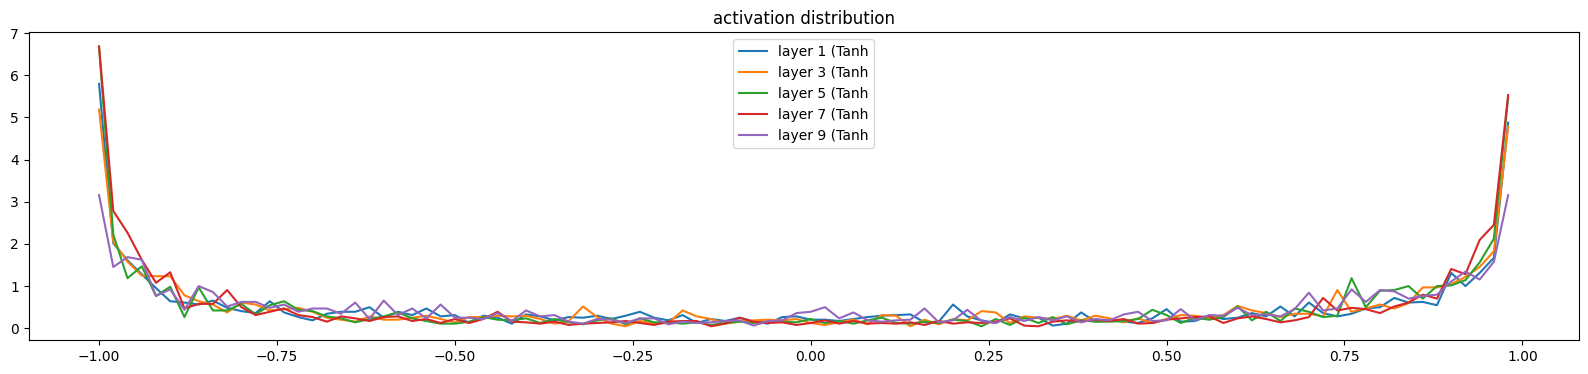

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean: %+.2f, std: %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000041, std 2.632885e-03
layer 3 (      Tanh): mean -0.000004, std 2.333225e-03
layer 5 (      Tanh): mean +0.000001, std 2.513105e-03
layer 7 (      Tanh): mean -0.000129, std 3.069803e-03
layer 9 (      Tanh): mean -0.000040, std 3.407326e-03


Text(0.5, 1.0, 'gradient distribution')

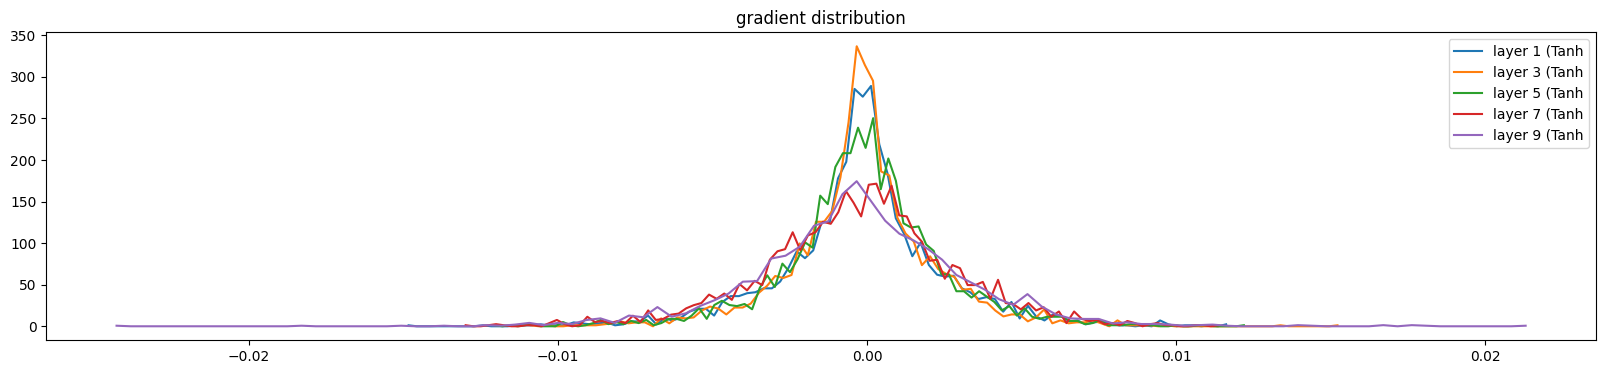

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000785 | std 1.017147e-02 | grad:data ratio 9.819573e-03
weight  (30, 100) | mean -0.000086 | std 7.958266e-03 | grad:data ratio 2.378418e-02
weight (100, 100) | mean +0.000081 | std 5.215222e-03 | grad:data ratio 2.799505e-02
weight (100, 100) | mean -0.000005 | std 4.982162e-03 | grad:data ratio 2.683786e-02
weight (100, 100) | mean +0.000024 | std 5.492941e-03 | grad:data ratio 2.996714e-02
weight (100, 100) | mean +0.000027 | std 7.352273e-03 | grad:data ratio 4.184441e-02
weight  (100, 27) | mean +0.000000 | std 2.290792e-02 | grad:data ratio 1.955249e-01


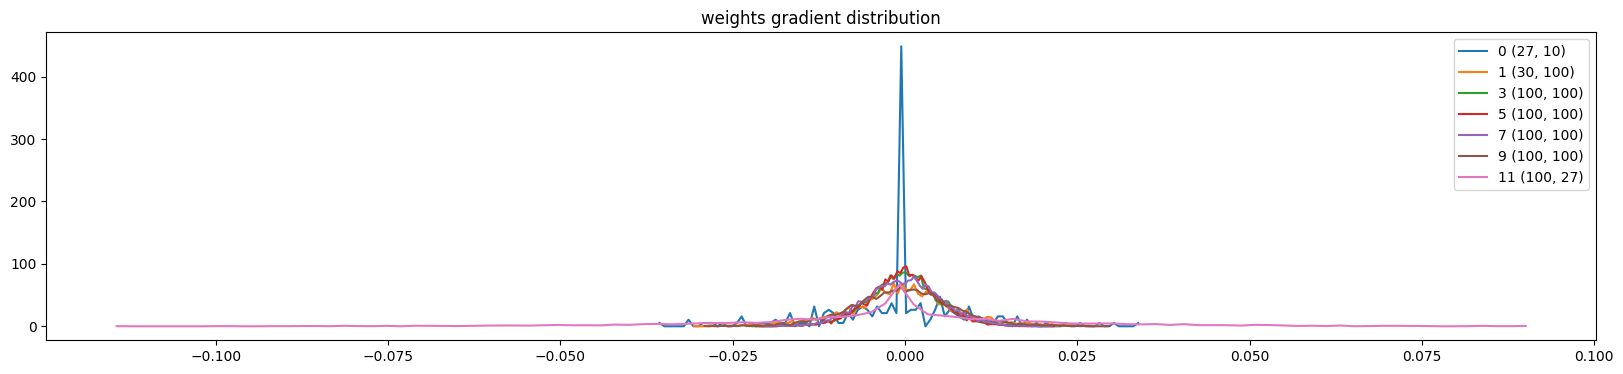

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

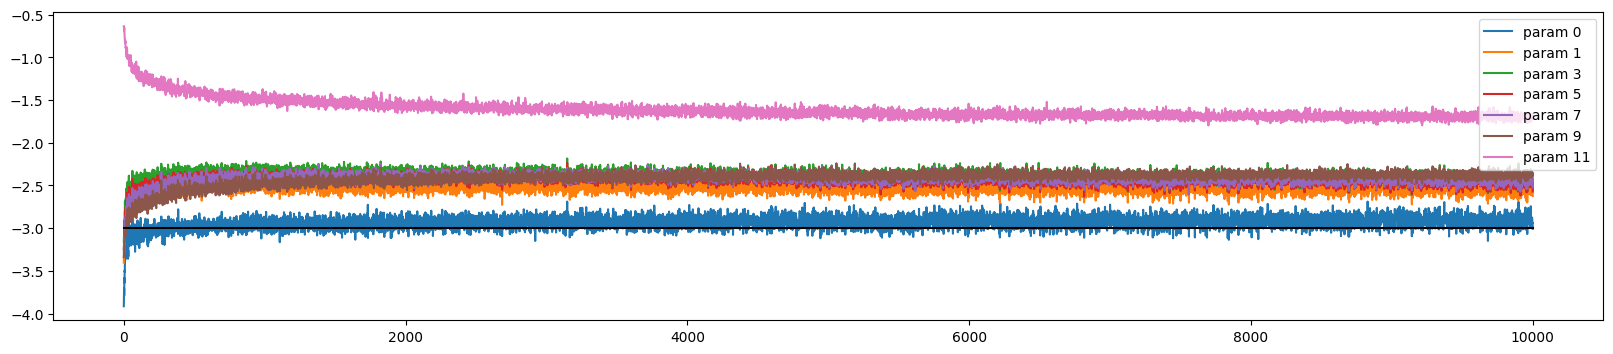

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### Bringing Back Batchnorm

In [ ]:
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 100 # number of Neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # make last layer less confident (layer softening)
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # gamma is basically the weight of the Batchnorm layer
    # all other Linear layers: remove the gain
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000
lossi = []
ud = [] # update to data ratio

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    x = emb.view(emb.shape[0], -1)
    for layer in layers: # MLP
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.15 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i >= 10000:
        break

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.2928192615509033 | Learning Rate: 0.15
Loss on iteration 10000: 2.512387752532959 | Learning Rate: 0.15
Final Loss:  2.512387752532959


layer 2 (      Tanh): mean: -0.00, std: 0.64, saturated: 6.41%
layer 5 (      Tanh): mean: -0.01, std: 0.67, saturated: 7.00%
layer 8 (      Tanh): mean: -0.01, std: 0.68, saturated: 4.97%
layer 11 (      Tanh): mean: -0.00, std: 0.69, saturated: 4.19%
layer 14 (      Tanh): mean: -0.01, std: 0.70, saturated: 2.97%


Text(0.5, 1.0, 'activation distribution')

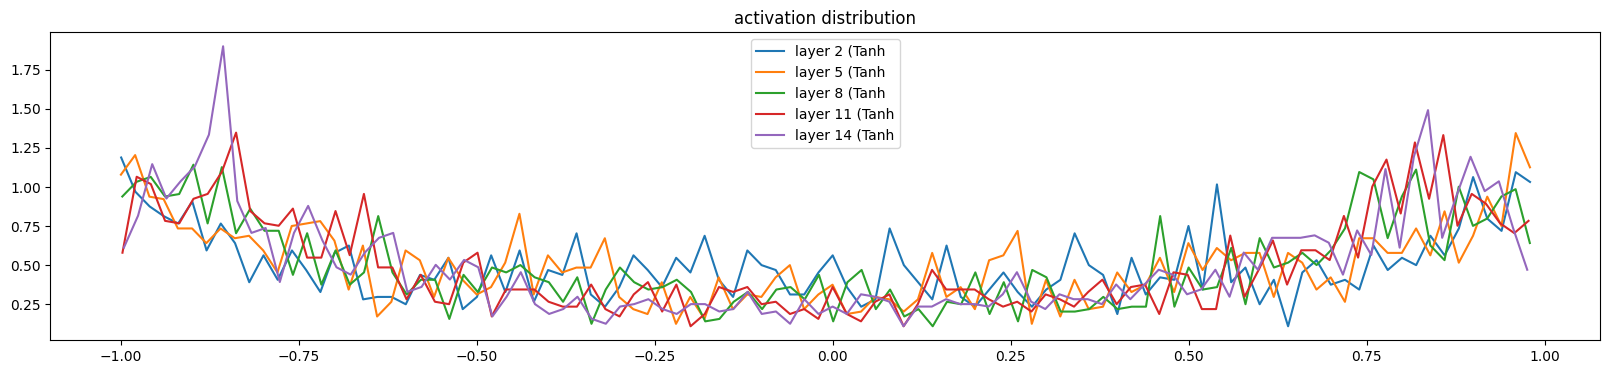

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean: %+.2f, std: %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.303358e-03
layer 5 (      Tanh): mean -0.000000, std 2.087991e-03
layer 8 (      Tanh): mean +0.000000, std 2.040828e-03
layer 11 (      Tanh): mean +0.000000, std 2.158716e-03
layer 14 (      Tanh): mean -0.000000, std 2.355688e-03


Text(0.5, 1.0, 'gradient distribution')

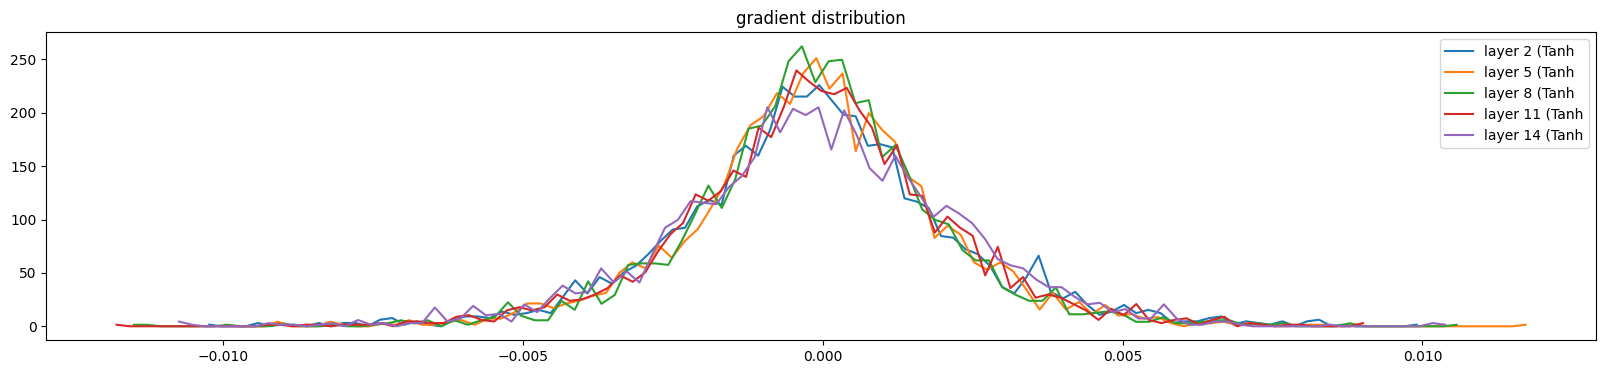

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.388512e-03 | grad:data ratio 8.300263e-03
weight  (30, 100) | mean +0.000074 | std 7.122967e-03 | grad:data ratio 3.100478e-02
weight (100, 100) | mean -0.000034 | std 4.151512e-03 | grad:data ratio 3.180871e-02
weight (100, 100) | mean -0.000034 | std 4.338936e-03 | grad:data ratio 3.430137e-02
weight (100, 100) | mean +0.000011 | std 4.419182e-03 | grad:data ratio 3.587241e-02
weight (100, 100) | mean +0.000010 | std 4.358759e-03 | grad:data ratio 3.608133e-02
weight  (100, 27) | mean -0.000193 | std 9.672665e-03 | grad:data ratio 5.769039e-02


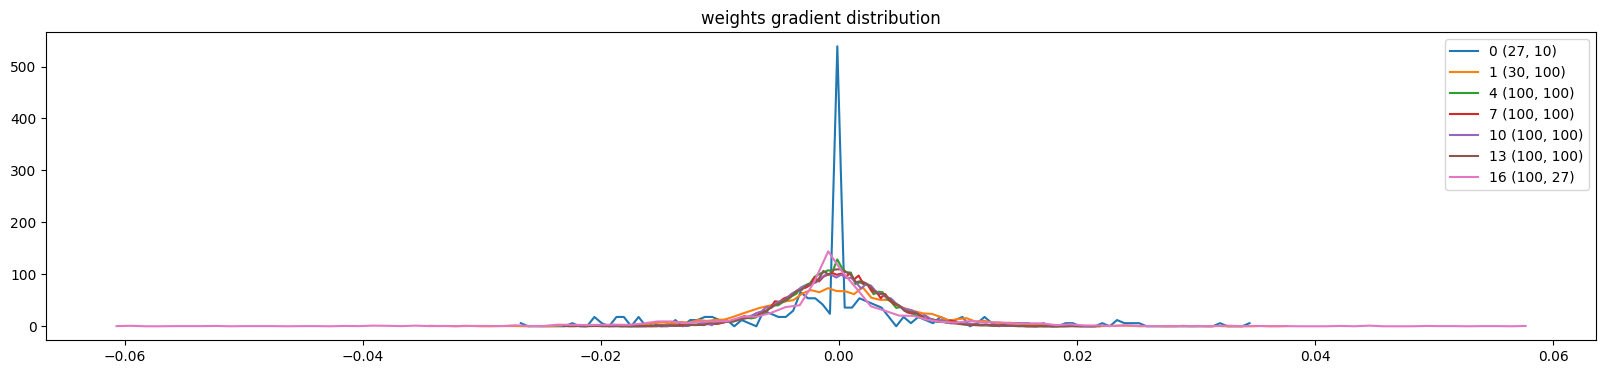

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

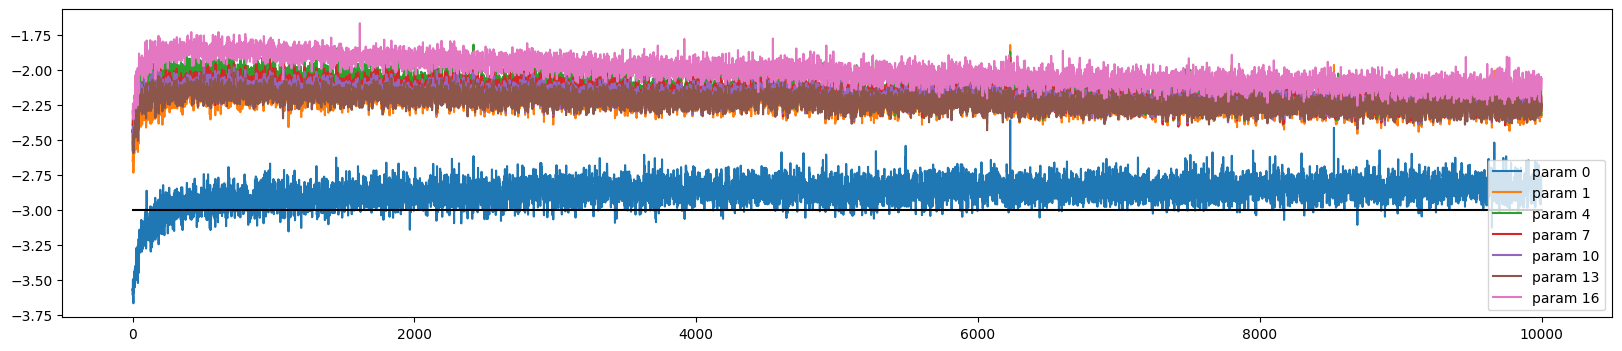

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
# if last plot is too low, then learning rate is too small, increase it
# if last plot is too high, learning rate it too big, decrease it
plt.legend(legends);